In [1]:
import sys
from numpy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
%matplotlib inline

In [2]:
df = pd.read_csv("LoanStats3d.csv",skiprows=1,low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 137 entries, id to hardship_last_payment_amount
dtypes: float64(104), object(33)
memory usage: 440.1+ MB


In [3]:
blank_columns = df.columns[df.isnull().all()].tolist()
blank_columns

['member_id',
 'url',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_il_6m',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [4]:
# drop blank columns
df = df.drop(['id','member_id', 'url','revol_bal_joint','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
 'sec_app_open_acc','sec_app_revol_util','sec_app_open_il_6m','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog'], axis = 1)

In [5]:
# drop post loan variables
df = df.drop(['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'grade', 'sub_grade','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d',
              'payment_plan_start_date','issue_d'], axis = 1)

In [6]:
df = df.drop(['term','int_rate','installment'], axis = 1)

In [7]:
# drop hardship variables
df = df.drop(['hardship_flag','hardship_type','hardship_reason', 'hardship_status','hardship_start_date',
             'hardship_end_date','hardship_loan_status', 'hardship_amount','hardship_length','hardship_dpd',
              'hardship_payoff_balance_amount','hardship_last_payment_amount'], axis = 1)

## Object variable wrangling
### a. Target variable: How many class of loan status are there?

In [8]:
obj_df = df.select_dtypes(include=['object']).copy()

In [9]:
pd.unique(obj_df['loan_status'].values.ravel())

array(['Current', 'Fully Paid', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', nan], dtype=object)

In [10]:
# classified loan_status to "good loan" and "bad loan''
status_dict = {'loan_status': {'Current':'0', 'Fully Paid':'0', 'In Grace Period':'0', 'Charged Off':'1', 'Late (16-30 days)':'1',
                'Late (31-120 days)':'1', 'Default':'1'}}
obj_df.replace(status_dict, inplace=True)
obj_df["loan_status"] = obj_df["loan_status"].astype('category')
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 16 columns):
emp_title                    397221 non-null object
emp_length                   421095 non-null object
home_ownership               421095 non-null object
verification_status          421095 non-null object
loan_status                  421095 non-null category
pymnt_plan                   421095 non-null object
desc                         45 non-null object
purpose                      421095 non-null object
title                        420963 non-null object
zip_code                     421095 non-null object
addr_state                   421095 non-null object
earliest_cr_line             421095 non-null object
revol_util                   420933 non-null object
initial_list_status          421095 non-null object
application_type             421095 non-null object
verification_status_joint    511 non-null object
dtypes: category(1), object(15)
memory usage: 48.6+ MB


### b. Data cleaning for other object variables

In [11]:
obj_df.revol_util = pd.Series(obj_df.revol_util).str.replace('%', '').astype(float)

In [12]:
obj_df.emp_length.value_counts()

10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
n/a           23817
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64

In [13]:
obj_df.replace('n/a', np.nan,inplace=True)
#obj_df.emp_length.fillna(value=0,inplace=True)
obj_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
obj_df['emp_length'] = obj_df['emp_length'].astype(float)

##### Employment Length
Leaving this variable in might contradict our decision to drop the employment tile as it also conveyed a sort of socio-economic seniority. A Computer Scientist 5 years into their career would generally have a larger salary than a Kindergarden teacher 10 years into their career. Arguably it might be powerful to combine a grouped, matched, and reduced set of employment titles with their length to create a "purchasing power" metric. Since employment length is an easy scalar, let's leave it in for now. We could leave 'emp_length' as categorical data, but it shouldn't be treated as such or as ordinal data since the intervals are easy to determine. We can convert it into numerical data with a simple filter:

### c.  Date engineering

### emp_title
This variable has 120813 categories and we can choose the top ten employment tiltle and create 10 dummy variables so it can be used in model building.

In [14]:
obj_df.emp_title.unique().shape

(120813,)

In [15]:
obj_df['emp_title'].str.lower().value_counts().head(10)

teacher             9956
manager             8958
owner               6101
registered nurse    4443
supervisor          4080
driver              3863
sales               3759
rn                  3545
office manager      2826
project manager     2734
Name: emp_title, dtype: int64

In [16]:
obj_df['emp_title'] = obj_df['emp_title'].str.lower().replace('rn', 'registered nurse')

In [21]:
cats = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
obj_df.loc[~ (obj_df['emp_title'].isin(cats)), 'emp_title'] = 'other'
obj_df.emp_title.value_counts()

other               368270
teacher               9956
manager               8958
registered nurse      7988
owner                 6101
supervisor            4080
driver                3863
sales                 3759
office manager        2826
project manager       2734
general manager       2562
Name: emp_title, dtype: int64

In [22]:
pd.get_dummies(obj_df, columns=["emp_title"], prefix=["emp_T"]).head()

,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,...,emp_T_general manager,emp_T_manager,emp_T_office manager,emp_T_other,emp_T_owner,emp_T_project manager,emp_T_registered nurse,emp_T_sales,emp_T_supervisor,emp_T_teacher
0,6.0,MORTGAGE,Not Verified,0,n,NaN,debt_consolidation,Debt consolidation,381xx,TN,...,0,0,0,1,0,0,0,0,0,0
1,2.0,RENT,Not Verified,0,n,NaN,debt_consolidation,Debt consolidation,477xx,IN,...,0,0,0,1,0,0,0,0,0,0
2,1.0,RENT,Source Verified,0,n,NaN,credit_card,Credit card refinancing,441xx,OH,...,0,0,0,1,0,0,0,0,0,0
3,NaN,OWN,Not Verified,0,n,NaN,home_improvement,Home improvement,376xx,TN,...,0,0,0,1,0,0,0,0,0,0
4,10.0,MORTGAGE,Verified,0,n,NaN,debt_consolidation,Debt consolidation,546xx,WI,...,0,0,0,1,0,0,0,0,0,0


### Zip code and state
This two variables can't be used directly for the analysis of loan status. But if they combined with the local unemployment rates in US they will be useful for the analysis for decision of the loan.

In [25]:
obj_df['zip_code'] = obj_df['zip_code'].str.replace('xx', '00')
unemp_zip = pd.read_csv('unemploy_zip.csv')
unemp_zip.info()
unemp_zip.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 3 columns):
state       855 non-null object
zip_code    855 non-null int64
Rate        855 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.1+ KB


,state,zip_code,Rate
0,AK,99500,8.48
1,AK,99600,8.69
2,AK,99700,8.41
3,AK,99800,7.64
4,AK,99900,9.00


In [26]:
# concate the two files
obj_df['zip_code'] = obj_df['zip_code'].astype('float')
obj_df = obj_df.rename(columns={'addr_state':'state'})
unemp_zip['zip_code'] = unemp_zip['zip_code'].astype('float')
obj_df1 = pd.merge(obj_df, unemp_zip, on=['state','zip_code'], how='left')
obj_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421097 entries, 0 to 421096
Data columns (total 17 columns):
emp_title                    421097 non-null object
emp_length                   397278 non-null float64
home_ownership               421095 non-null object
verification_status          421095 non-null object
loan_status                  421095 non-null category
pymnt_plan                   421095 non-null object
desc                         45 non-null object
purpose                      421095 non-null object
title                        420963 non-null object
zip_code                     421095 non-null float64
state                        421095 non-null object
earliest_cr_line             421095 non-null object
revol_util                   420933 non-null float64
initial_list_status          421095 non-null object
application_type             421095 non-null object
verification_status_joint    511 non-null object
Rate                         387468 non-null float64
dtypes

There are 815 zip_unemployment rate in unemp_zip files while there are 915 zip code in lending club dataset. So there are missing values for the unemployment rate when this two files are merged together.

## Numerical variables wrangling

In [27]:
num_df = df.select_dtypes(include=['float']).copy()

In [28]:
# fine the numerical variables which have more than 10% of outliers
for col in num_df.columns:
    Q1 = num_df[col].quantile(0.25)
    Q3 = num_df[col].quantile(0.75)
    IQR = Q3 - Q1
    out_liers_number = ((num_df[col] < (Q1 - 3 * IQR)) | (num_df[col] > (Q3 + 3 * IQR))).sum()
    count = df[col].count()
    if out_liers_number > (0.1 * count):
        print ("Column {} has {} outliers".format(col, out_liers_number)) 

#from scipy import stats
#df[(np.abs(stats.zscore(df)) > 3).all(axis=1)]

Column delinq_2yrs has 87087 outliers
Column pub_rec has 74415 outliers
Column tot_coll_amt has 66407 outliers
Column num_accts_ever_120_pd has 102993 outliers
Column pub_rec_bankruptcies has 50916 outliers


In [29]:
df1 = pd.concat([obj_df1, num_df], axis=1 )

### Explanatory Data Analysis

In [31]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

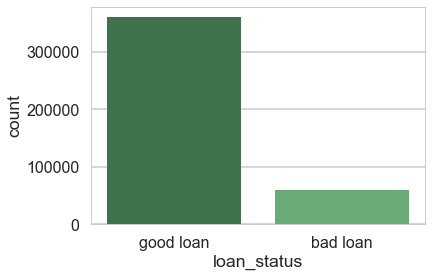

In [34]:
_ = sns.countplot(x="loan_status", data=df1, palette="Greens_d");
_.set_xticklabels(['good loan', 'bad loan'])

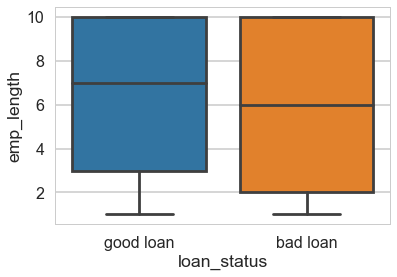

In [45]:
_ = sns.boxplot(x='loan_status', y='emp_length',data=df1)
_.set_xticklabels(['good loan', 'bad loan'])

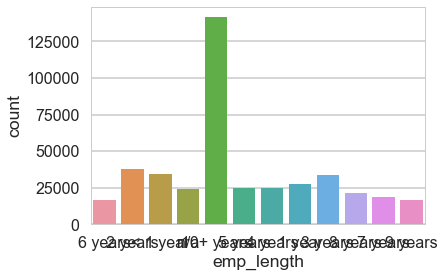

In [44]:
sns.countplot(x='emp_length', data=df)

In [50]:
def as_percent(val, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(val, Number):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

In [70]:
df2=df[df.emp_title.isin(cats)][['loan_status', 'emp_title']]

In [71]:
df2.head()

,loan_status,emp_title
3,Current,NaN
72,Fully Paid,NaN
75,Current,NaN
87,Current,general manager
104,Current,driver


In [72]:
good_loan_data = df2[df2.loan_status.isin(['Current', 'Fully Paid', 'In Grace Period'])]
bad_loan_data = df2[df2.loan_status.isin(['Charged Off', 'Late (16-30 days)',
                'Late (31-120 days)', 'Default'])]

In [73]:
good_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28040 entries, 3 to 421076
Data columns (total 2 columns):
loan_status    28040 non-null object
emp_title      8513 non-null object
dtypes: object(2)
memory usage: 657.2+ KB


In [74]:
good_loan_emptitle = good_loan_data.groupby(['emp_title']).size().values
bad_loan_emptitle = bad_loan_data.groupby(['emp_title']).size().values

In [75]:
totals = good_loan_emptitle + bad_loan_emptitle
data1_percentages = calculate_percentage(good_loan_emptitle, totals)*100 
data2_percentages = calculate_percentage(bad_loan_emptitle, totals)*100
emp_title_categories = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']

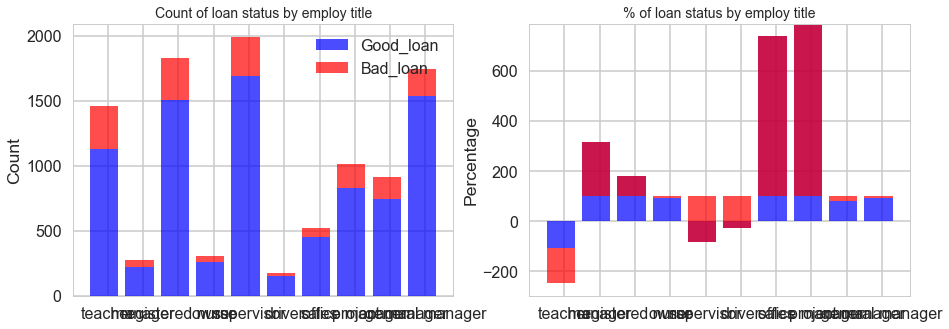

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot chart for count of survivors by class
ax1.bar(range(len(good_loan_emptitle)), good_loan_emptitle, label='Good_loan', alpha=0.7, color='b')
ax1.bar(range(len(bad_loan_emptitle)), bad_loan_emptitle, bottom=good_loan_emptitle, label='Bad_loan', alpha=0.7, color='r')
plt.sca(ax1)
plt.xticks([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1], emp_title_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of loan status by employ title",fontsize=14)
plt.legend(loc='upper right')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data2_percentages)), data2_percentages, alpha=0.7, color='b')
ax2.bar(range(len(data1_percentages)), data1_percentages, bottom=data2_percentages, alpha=0.7, color='r')
plt.sca(ax2)
plt.xticks([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1],  emp_title_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of loan status by employ title",fontsize=14)

In [ ]:
# Count number of passengers and number of survivors in sample data
good_loan_data = df1[df1.loan_status==0]
bad_loan_data = df1[df1.loan_status==1]

# calculate values for each survival status
df2=df1[df1.emp_title.isin(cats)]
survivors_gender = survivors_data.groupby(['Sex']).size().values
non_survivors_gender = non_survivors_data.groupby(['Sex']).size().values

# calculate totals for percentates
totals = survivors_gender + non_survivors_gender

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_gender, totals)*100 
data2_percentages = calculate_percentage(non_survivors_gender, totals)*100 

gender_categories = ['Female', 'Male']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_gender)), survivors_gender, label='Survivors', alpha=0.7, color='b')
ax1.bar(range(len(non_survivors_gender)), non_survivors_gender, bottom=survivors_gender, label='Non-Survivors', alpha=0.7, color='r')
plt.sca(ax1)
plt.xticks([0.4, 1.4], gender_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by gender",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.7, color='b')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.7, color='r')
plt.sca(ax2)
plt.xticks([0.4, 1.4],  gender_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by gender",fontsize=14)

In [ ]:
#df.verification_status.value_counts()

In [ ]:
#df.purpose.value_counts()

In [ ]:
#df.title.value_counts()

In [ ]:
import seaborn as sns
print(obj_df.loan_status.value_counts())

issue_d_todate = pd.to_datetime(df.issue_d)# (df['issue_d'].apply(lambda x: x.strftime('%Y-%m-%d')))
df.issue_d = pd.Series(df.issue_d).str.replace('-2015', '')
# We need sort_index() or else we won't get a sequential timedate order.
issue_d_todate.value_counts().sort_index().plot(kind='bar')

# Delinquency
Lets examine the distribution of delinquency across all applicants:

In [ ]:
# df.delinq_2yrs.value_counts()

In [ ]:
from datetime import datetime               # There are NaN in this column

# df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

# dttoday = datetime.now().strftime('%Y-%m-%d')
# There is a better way to do this :) 
# df.earliest_cr_line = df.earliest_cr_line.apply(lambda x: (
#        np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)


In [ ]:
for col in obj_df.columns:
    print ("Column {} has {} unique instances".format( col, len(df[col].unique())) )

In [ ]:
obj_df['loan_status'].value_counts().plot(kind='bar')

In [ ]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]